In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from explore import count_dict_items, find_in_movie, movie_search, movie_search_aggregate, box_office_from_search, barplot_movies, count_winning_pairs, dataframe_dictionary
from sklearn import preprocessing
from scipy import stats
from itertools import chain
from collections import Counter
from datetime import datetime
from dateutil.relativedelta import relativedelta
from math import inf

import calendar
import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set(style="ticks")

### READ

In [3]:
train_df = pd.read_csv("data/train.csv")

### CLEAN

In [4]:
dictionary_columns = ["belongs_to_collection", "genres", "production_companies", "production_countries", "spoken_languages", "Keywords", "cast", "crew"]

for column in dictionary_columns:
    train_df[column] = train_df[column].apply(lambda row: ast.literal_eval(row) if not pd.isna(row) else [{"name": "NO DATA"}])
    
train_df["release_date"] = pd.to_datetime(train_df["release_date"])
train_df["release_date"] = train_df["release_date"].apply(lambda row: row - relativedelta(years=100) if row >= datetime.now() else row)

train_df = train_df[(train_df["budget"] >= 15_000) & (train_df["revenue"] >= 100_000)]

### CALCULATE

In [5]:
train_df["roi"] = train_df["revenue"] / train_df["budget"]
train_df["adjusted_roi"] = train_df["revenue"] / (train_df["budget"] * 2)

train_df["release_year"] = train_df["release_date"].map(lambda x: x.year)
train_df["release_month"] = train_df["release_date"].map(lambda x: x.month)
train_df["release_day_of_week"] = train_df["release_date"].dt.dayofweek

# used min max scaler to normalize large numbers
train_df["normalized_popularity"] = preprocessing.MinMaxScaler().fit_transform(np.array(train_df["popularity"]).reshape((-1,1)))
train_df["normalized_budget"] = preprocessing.MinMaxScaler().fit_transform(np.array(train_df["budget"]).reshape((-1,1)))
train_df["normalized_runtime"] = preprocessing.MinMaxScaler().fit_transform(np.array(train_df["runtime"]).reshape((-1,1)))
train_df["normalized_revenue"] = preprocessing.MinMaxScaler().fit_transform(np.array(train_df["revenue"]).reshape((-1,1)))

### DESCRIBE

In [6]:
train_df.loc[:, train_df.columns != "id"].describe()

budget   popularity      runtime       revenue           roi  \
count  2.091000e+03  2091.000000  2091.000000  2.091000e+03   2091.000000   
mean   3.213771e+07     9.960269   110.519847  9.090978e+07     12.545935   
std    4.074913e+07    13.996276    22.432759  1.579297e+08    296.055279   
min    1.500000e+04     0.003013     0.000000  1.006590e+05      0.005165   
25%    6.000000e+06     5.671845    96.000000  8.487733e+06      0.882709   
50%    1.800000e+07     8.473369   106.000000  3.220403e+07      2.081863   
75%    4.000000e+07    11.806200   121.000000  1.030759e+08      4.211848   
max    3.800000e+08   294.337037   338.000000  1.519558e+09  12890.386667   

       adjusted_roi  release_year  release_month  release_day_of_week  \
count   2091.000000   2091.000000    2091.000000          2091.000000   
mean       6.272967   2000.017217       6.877571             3.220469   
std      148.027640     15.430805       3.408170             1.306840   
min        0.002582   1921.000000       1.000000             0.000000   
25%        0.441354   1994.000000       4.000000             2.000000   
50%        1.040932   2004.000000       7.000000             4.000000   
75%        2.105924   2011.000000      10.000000             4.000000   
max     6445.193333   2017.000000      12.000000             6.000000   

       normalized_popularity  normalized_budget  normalized_runtime  \
count            2091.000000        2091.000000         2091.000000   
mean                0.033830           0.084537            0.326982   
std                 0.047552           0.107239            0.066369   
min                 0.000000           0.000000            0.000000   
25%                 0.019260           0.015751            0.284024   
50%                 0.028778           0.047331            0.313609   
75%                 0.040101           0.105228            0.357988   
max                 1.000000           1.000000            1.000000   

       normalized_revenue  
count         2091.000000  
mean             0.059764  
std              0.103938  
min              0.000000  
25%              0.005520  
50%              0.021128  
75%              0.067771  
max              1.000000

In [7]:
train_df[["title", "budget", "revenue", "adjusted_roi"]].sort_values(by="budget", ascending=False)

title     budget     revenue  \
2135  Pirates of the Caribbean: On Stranger Tides  380000000  1045713802   
2209     Pirates of the Caribbean: At World's End  300000000   961000000   
2770                      Avengers: Age of Ultron  280000000  1405403694   
1425                             Superman Returns  270000000   391081192   
1630                Transformers: The Last Knight  260000000   604942143   
...                                           ...        ...         ...   
746                                    The Signal      50000      249905   
267                                        Clerks      27000     3151130   
259                                 The Terrorist      24554      140021   
2786                                   Bellflower      17000      101236   
1230                          Paranormal Activity      15000   193355800   

      adjusted_roi  
2135      1.375939  
2209      1.601667  
2770      2.509649  
1425      0.724224  
1630      1.163350  
...            ...  
746       2.499050  
267      58.354259  
259       2.851287  
2786      2.977529  
1230   6445.193333  

[2091 rows x 4 columns]

In [8]:
train_df[train_df["imdb_id"] == "tt0113189"]

id                              belongs_to_collection    budget  \
1095  1096  [{'id': 645, 'name': 'James Bond Collection', ...  58000000   

                                                 genres  \
1095  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...   

                                          homepage    imdb_id  \
1095  http://www.mgm.com/view/movie/757/Goldeneye/  tt0113189   

     original_language original_title  \
1095                en      GoldenEye   

                                               overview  popularity  \
1095  James Bond must unmask the mysterious head of ...   14.686036   

                           poster_path  \
1095  /5c0ovjT41KnYIHYuF4AWsTe3sKh.jpg   

                                   production_companies  \
1095  [{'name': 'United Artists', 'id': 60}, {'name'...   

                                   production_countries release_date  runtime  \
1095  [{'iso_3166_1': 'GB', 'name': 'United Kingdom'...   1995-11-16    130.0   

                                       spoken_languages    status  \
1095  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   

                                   tagline      title  \
1095  No limits. No fears. No substitutes.  GoldenEye   

                                               Keywords  \
1095  [{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam...   

                                                   cast  \
1095  [{'cast_id': 1, 'character': 'James Bond', 'cr...   

                                                   crew    revenue       roi  \
1095  [{'credit_id': '52fe426ec3a36847f801e14b', 'de...  352194034  6.072311   

      adjusted_roi  release_year  release_month  release_day_of_week  \
1095      3.036155          1995             11                    3   

      normalized_popularity  normalized_budget  normalized_runtime  \
1095               0.049886           0.152598            0.384615   

      normalized_revenue  
1095            0.231723

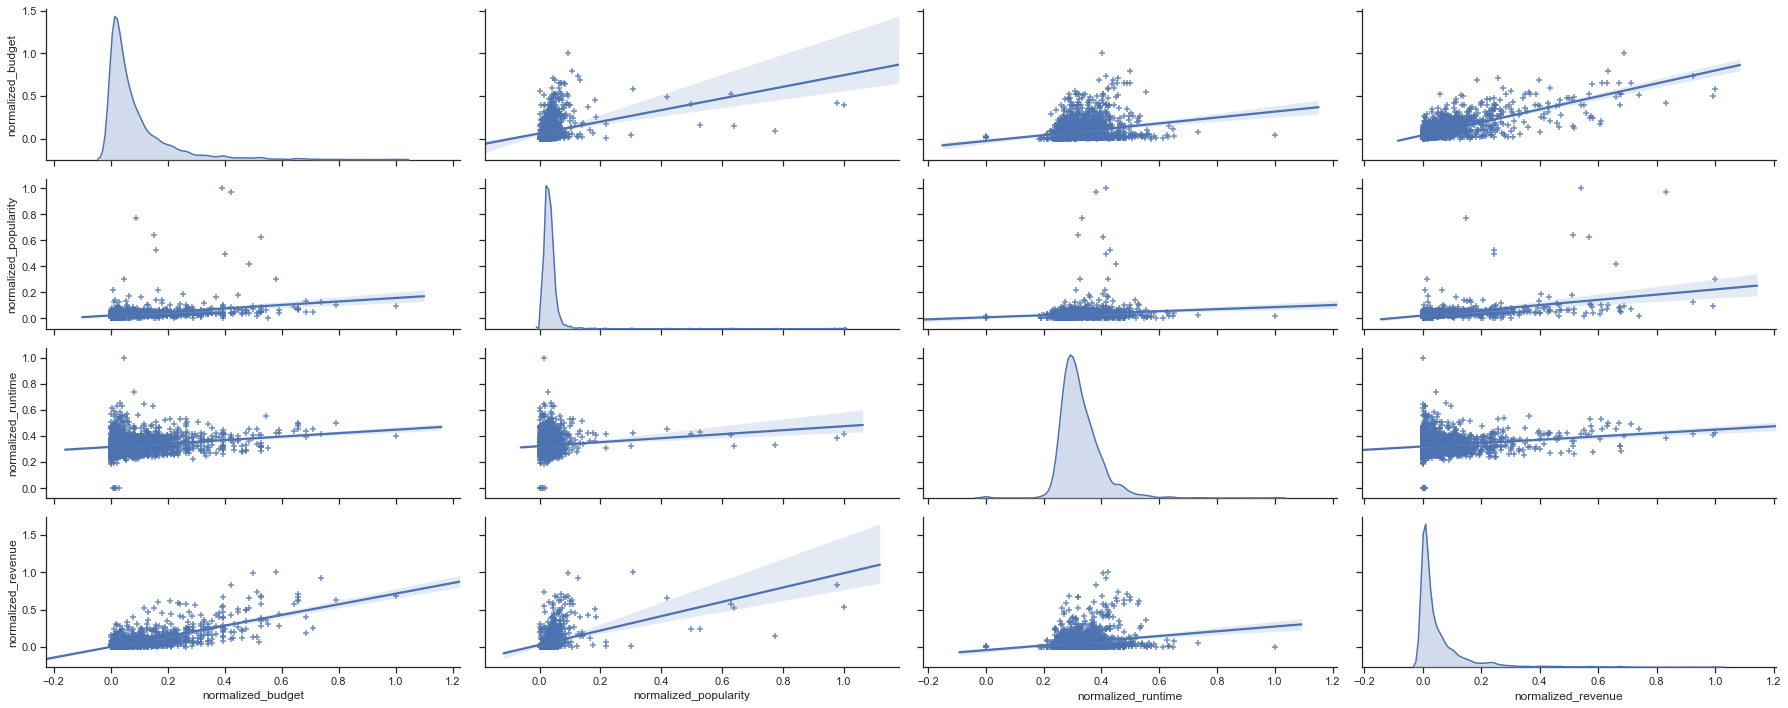

In [9]:
sns.pairplot(train_df[["normalized_budget", "normalized_popularity", "normalized_runtime", "normalized_revenue"]],
             markers="+", diag_kind="kde", kind="reg", aspect=2.5)

plt.tight_layout()

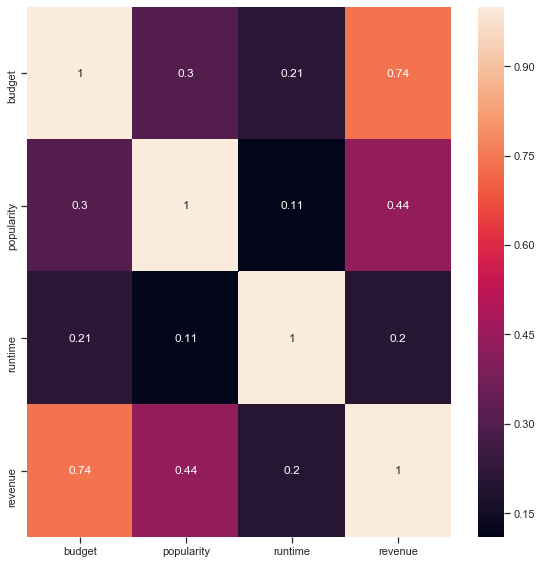

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(train_df[["budget", "popularity", "runtime", "revenue"]].corr(), annot=True)

plt.tight_layout()

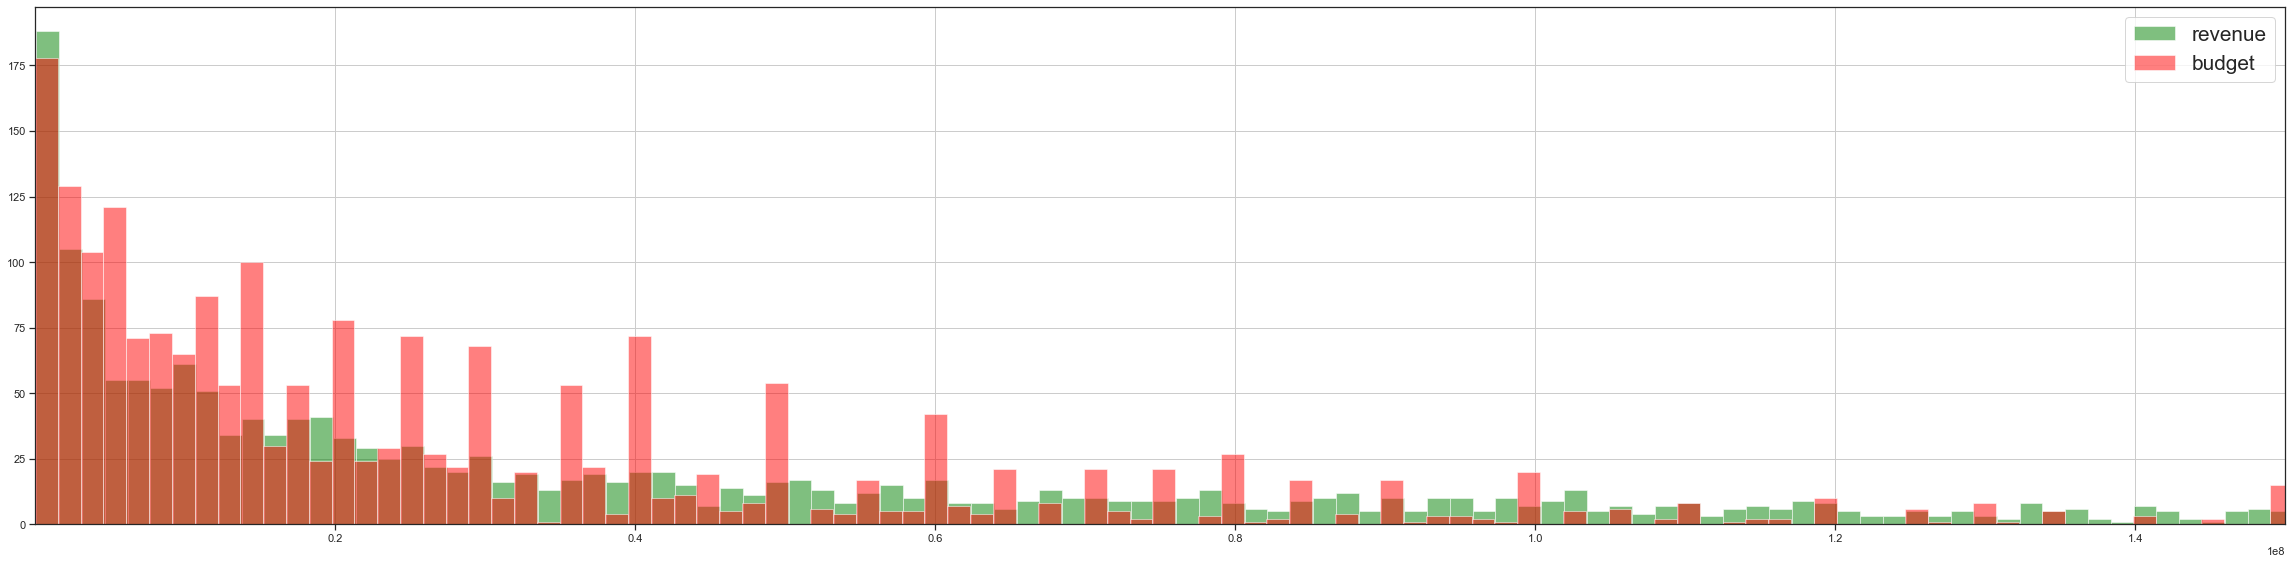

In [11]:
fig, ax = plt.subplots(figsize=(32, 8), sharex=True, sharey=True)

train_df["revenue"].hist(bins=1000, ax=ax, alpha=0.5, color="green")
train_df["budget"].hist(bins=250, ax=ax, alpha=0.5, color="red")

ax.set_xlim((15_000, 150_000_000))
# ax.set_ylim((0, 175))
ax.legend(["revenue", "budget"], fontsize="xx-large")

plt.tight_layout()

In [12]:
top_counts_df = count_dict_items(df=train_df, dct_columns=dictionary_columns)

top_counts_df.head(21)

belongs_to_collection                  genres  \
0                               (NO DATA, 1602)           (Drama, 1031)   
1                   (James Bond Collection, 16)           (Comedy, 696)   
2               (Friday the 13th Collection, 7)         (Thriller, 604)   
3                         (Rocky Collection, 4)           (Action, 596)   
4                       (Ice Age Collection, 4)          (Romance, 387)   
5      (The Fast and the Furious Collection, 4)        (Adventure, 368)   
6                         (Rambo Collection, 4)            (Crime, 359)   
7                         (Alien Collection, 4)  (Science Fiction, 240)   
8                 (Resident Evil Collection, 4)           (Horror, 231)   
9                  (Child's Play Collection, 4)           (Family, 194)   
10                 (Transformers Collection, 4)          (Fantasy, 184)   
11          (Paranormal Activity Collection, 4)          (Mystery, 176)   
12                    (Rush Hour Collection, 3)        (Animation, 105)   
13  (The Pink Panther (Original) Collection, 3)          (History, 100)   
14                     (The Jaws Collection, 3)               (War, 77)   
15         (Diary of a Wimpy Kid Collection, 3)             (Music, 68)   
16                         (Cars Collection, 3)           (Western, 29)   
17                   (Alex Cross Collection, 3)       (Documentary, 17)   
18                          (Mexico Trilogy, 3)            (Foreign, 7)   
19                 (Three Heroes Collection, 3)            (NO DATA, 4)   
20                (Indiana Jones Collection, 3)           (TV Movie, 1)   

                             production_companies  \
0                             (Warner Bros., 170)   
1                       (Universal Pictures, 154)   
2                       (Paramount Pictures, 132)   
3   (Twentieth Century Fox Film Corporation, 121)   
4                         (Columbia Pictures, 83)   
5                           (New Line Cinema, 68)   
6                 (Metro-Goldwyn-Mayer (MGM), 63)   
7                                   (NO DATA, 57)   
8                      (Walt Disney Pictures, 55)   
9                       (Touchstone Pictures, 50)   
10            (Columbia Pictures Corporation, 47)   
11                         (Relativity Media, 47)   
12                         (TriStar Pictures, 40)   
13                           (United Artists, 37)   
14                (Village Roadshow Pictures, 35)   
15                            (Miramax Films, 34)   
16                                   (Canal+, 32)   
17                       (Dune Entertainment, 28)   
18                           (DreamWorks SKG, 27)   
19                      (Regency Enterprises, 27)   
20                                (Lionsgate, 25)   

                production_countries spoken_languages  \
0   (United States of America, 1724)  (English, 1905)   
1              (United Kingdom, 255)  (Français, 190)   
2                      (France, 139)   (Español, 180)   
3                     (Germany, 127)   (Deutsch, 115)   
4                       (Canada, 89)   (Pусский, 113)   
5                        (India, 68)   (Italiano, 91)   
6                    (Australia, 46)        (日本語, 60)   
7                        (Italy, 41)        (普通话, 52)   
8                       (Russia, 34)     (हिन्दी, 48)   
9                        (Japan, 32)           (, 34)   
10                       (China, 32)  (Português, 32)   
11                       (Spain, 28)    (العربية, 32)   
12                   (Hong Kong, 24)    (한국어/조선말, 26)   
13                     (Belgium, 15)      (Latin, 23)   
14                     (NO DATA, 14)      (தமிழ், 21)   
15                 (New Zealand, 14)  (广州话 / 廣州話, 20)   
16                     (Ireland, 13)    (ภาษาไทย, 20)   
17              (Czech Republic, 13)     (Polski, 16)   
18                      (Mexico, 11)      (Český, 15)   
19                 (South Korea, 10)     (Magyar, 14)   
20         

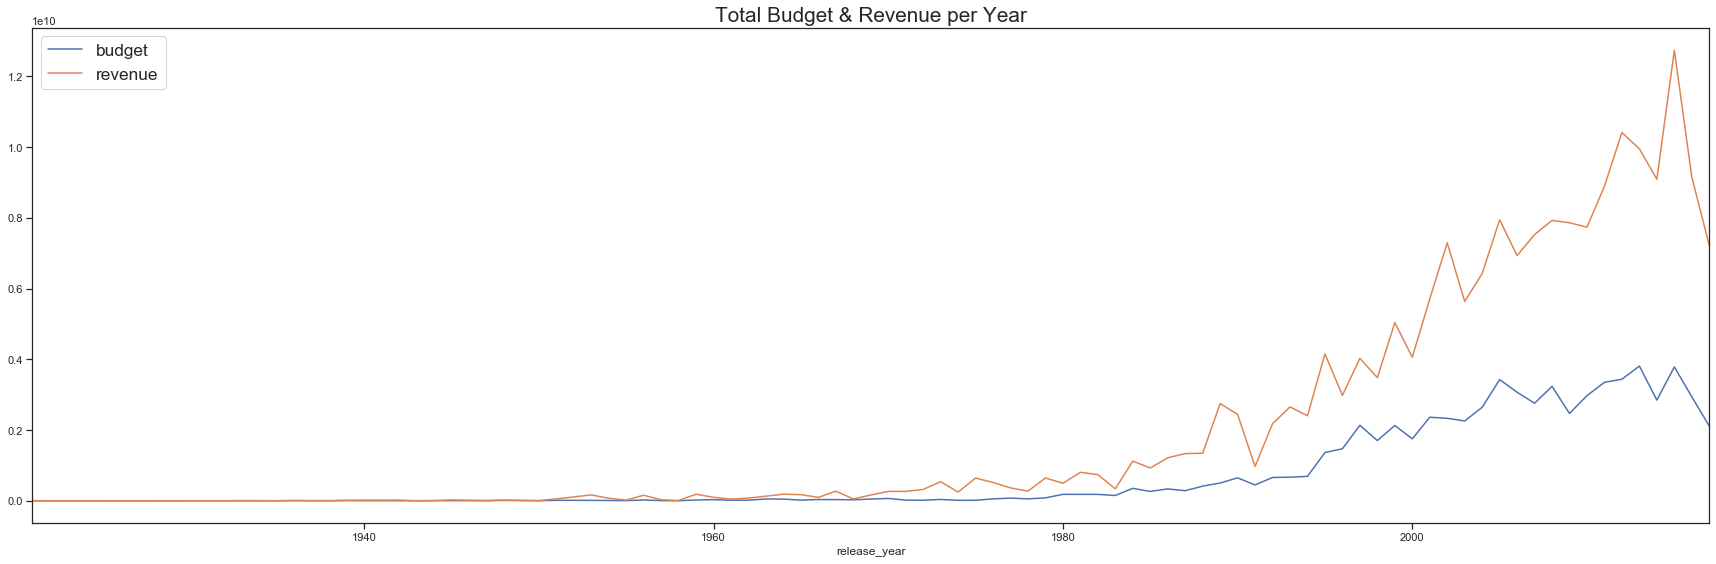

In [13]:
fig, ax = plt.subplots(figsize=(24,8))

train_df[["release_year", "budget", "revenue"]].groupby("release_year").sum().plot(ax=ax)

ax.set_title("Total Budget & Revenue per Year", fontsize="xx-large")

ax.legend(fontsize="x-large")

plt.tight_layout()

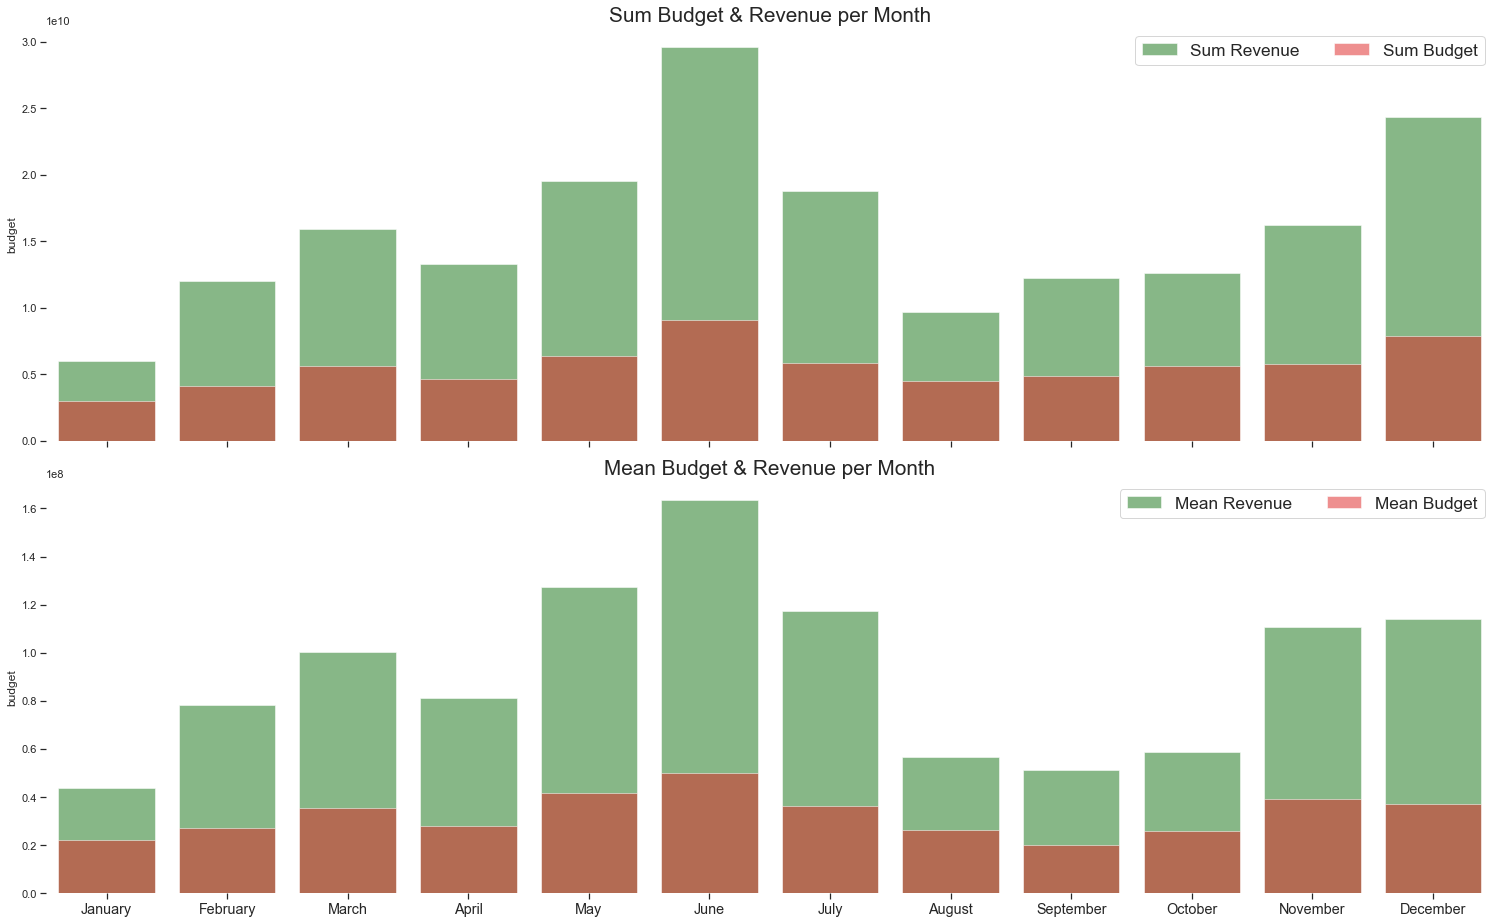

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(21,13), sharex=True, sharey=False)

data1 = train_df[["release_month", "budget", "revenue"]].groupby("release_month").sum()

sns.set_color_codes("colorblind")
sns.barplot(x=list(range(12)), y="revenue", data=data1, ax=ax1, label="Sum Revenue", color="green", alpha=0.5)

sns.barplot(x=list(range(12)), y="budget", data=data1, ax=ax1, label="Sum Budget", color="red", alpha=0.5)

ax1.set_xticks(range(12))
ax1.set_xticklabels(calendar.month_name[1:], fontsize="large")

ax1.set_title("Sum Budget & Revenue per Month", fontsize="xx-large")

ax1.legend(ncol=2, frameon=True, fontsize="x-large")
sns.despine(left=True, bottom=True)

########

data2 = train_df[["release_month", "budget", "revenue"]].groupby("release_month").mean()

sns.set_color_codes("colorblind")
sns.barplot(x=list(range(12)), y="revenue", data=data2, ax=ax2, label="Mean Revenue", color="green", alpha=0.5)

# sns.set_color_codes("muted")
sns.barplot(x=list(range(12)), y="budget", data=data2, ax=ax2, label="Mean Budget", color="red", alpha=0.5)

ax2.set_xticks(range(12))
ax2.set_xticklabels(calendar.month_name[1:], fontsize="large")

ax2.set_title("Mean Budget & Revenue per Month", fontsize="xx-large")

ax2.legend(ncol=2, frameon=True, fontsize="x-large")
sns.despine(left=True, bottom=True)

plt.tight_layout()

In [15]:
print("Jon Favreau as cast:")
print(movie_search(train_df, "Jon Favreau", "cast")[["adjusted_roi"]].mean())
print("Jon Favreau as crew:")
print(movie_search(train_df, "Jon Favreau", "crew")[["adjusted_roi"]].mean())

Jon Favreau as cast:
adjusted_roi    1.053394
dtype: float64
Jon Favreau as crew:
adjusted_roi    1.761765
dtype: float64


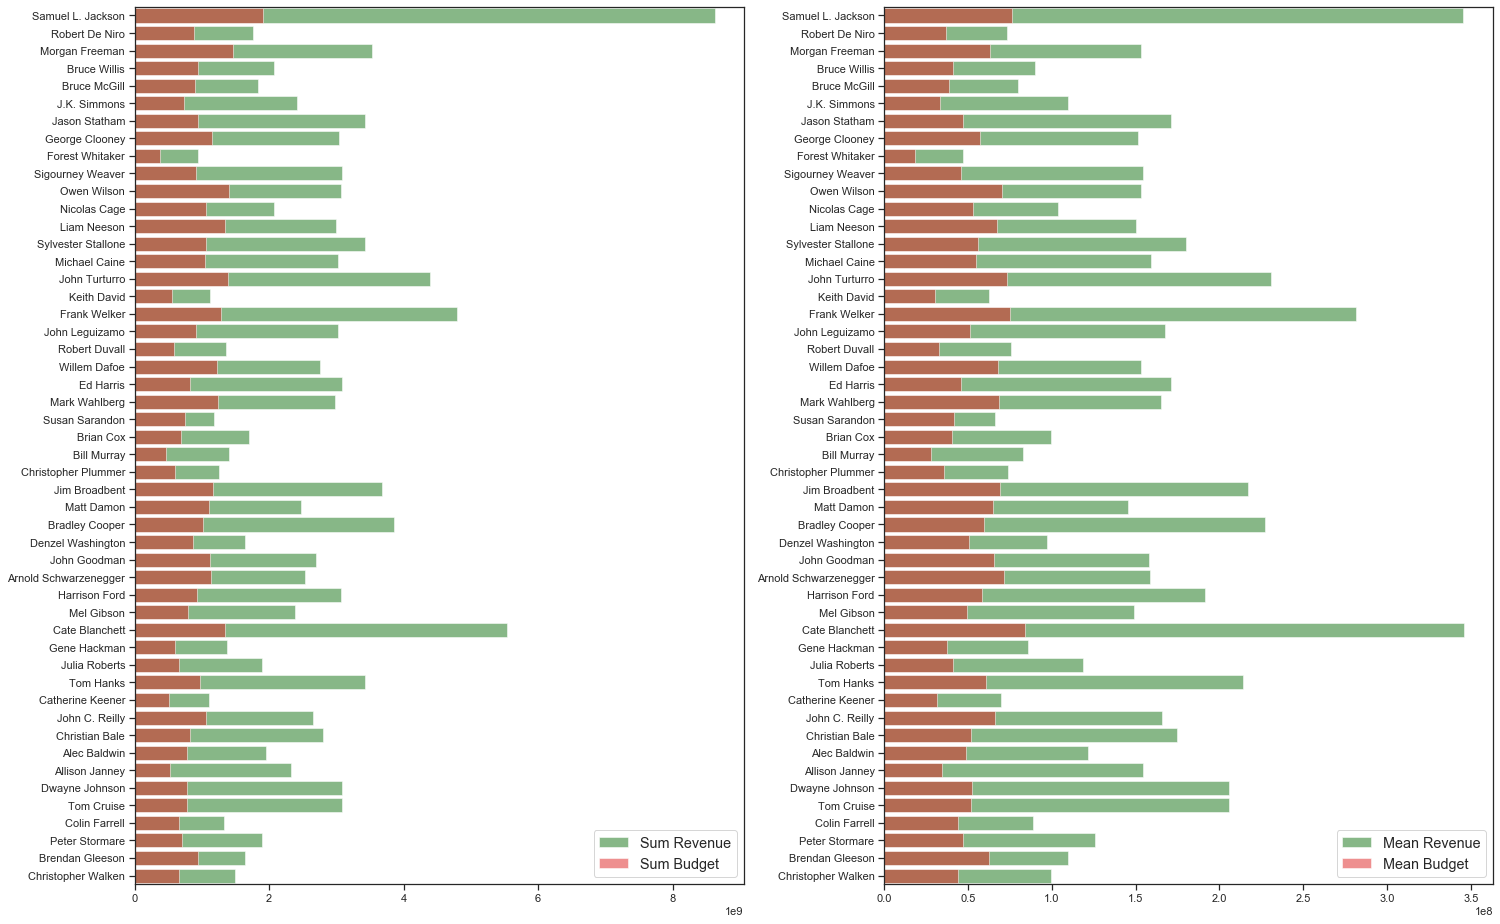

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 13), sharex=False)
ax1, ax2 = axes

barplot_movies(df=train_df, category="cast", agg="sum", ax=ax1, data_to_find=top_counts_df, top=50)
barplot_movies(df=train_df, category="cast", agg="mean", ax=ax2, data_to_find=top_counts_df, top=50)

plt.tight_layout()

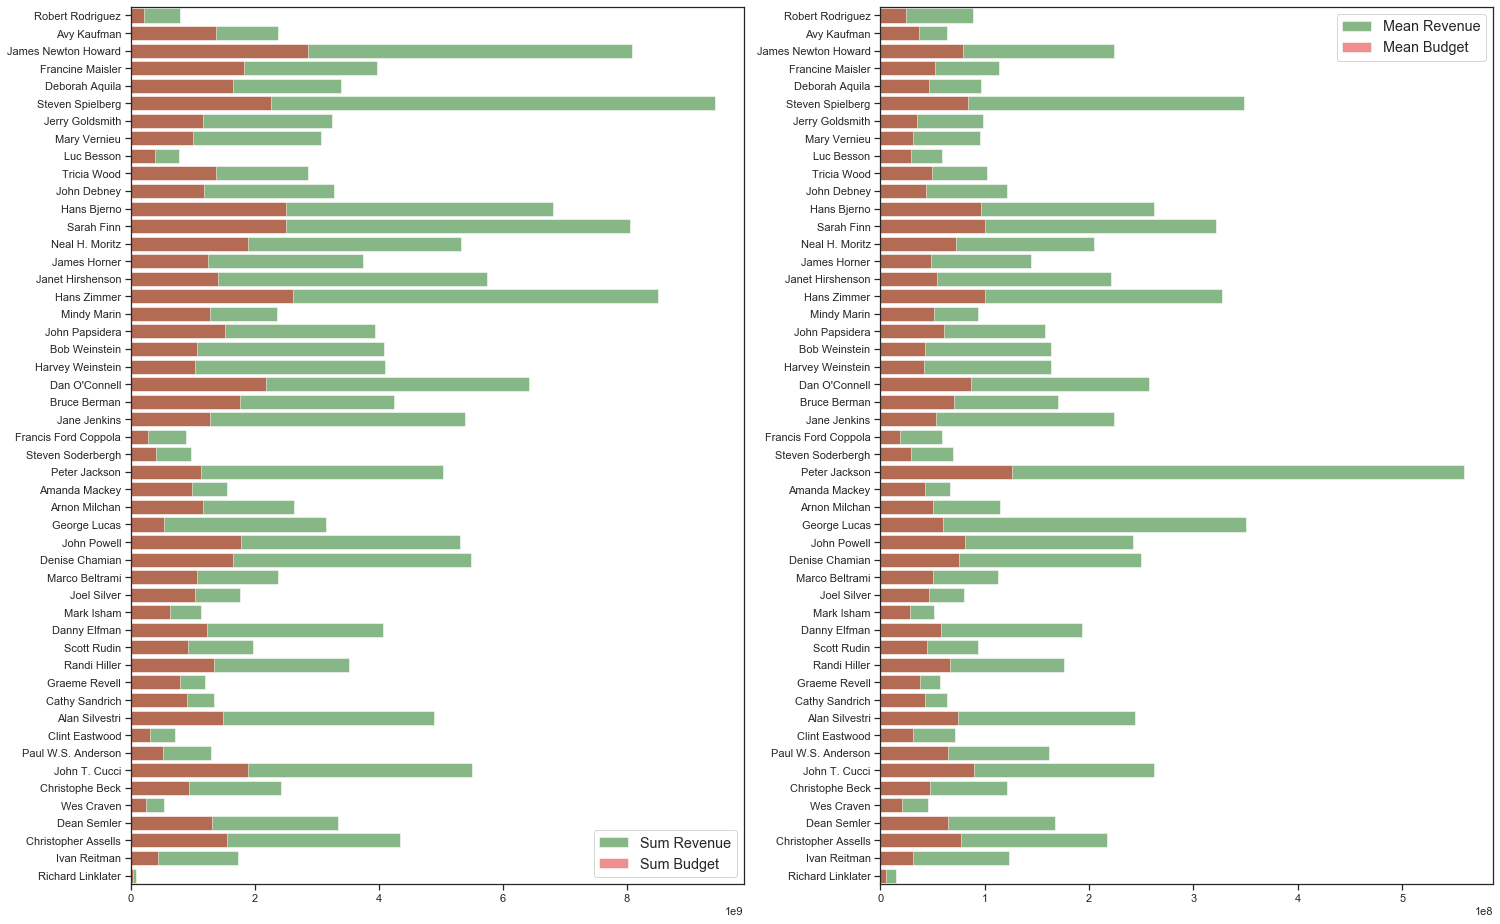

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 13), sharex=False)
ax1, ax2 = axes

barplot_movies(df=train_df, category="crew", agg="sum", ax=ax1, data_to_find=top_counts_df, top=50)
barplot_movies(df=train_df, category="crew", agg="mean", ax=ax2, data_to_find=top_counts_df, top=50)

plt.tight_layout()

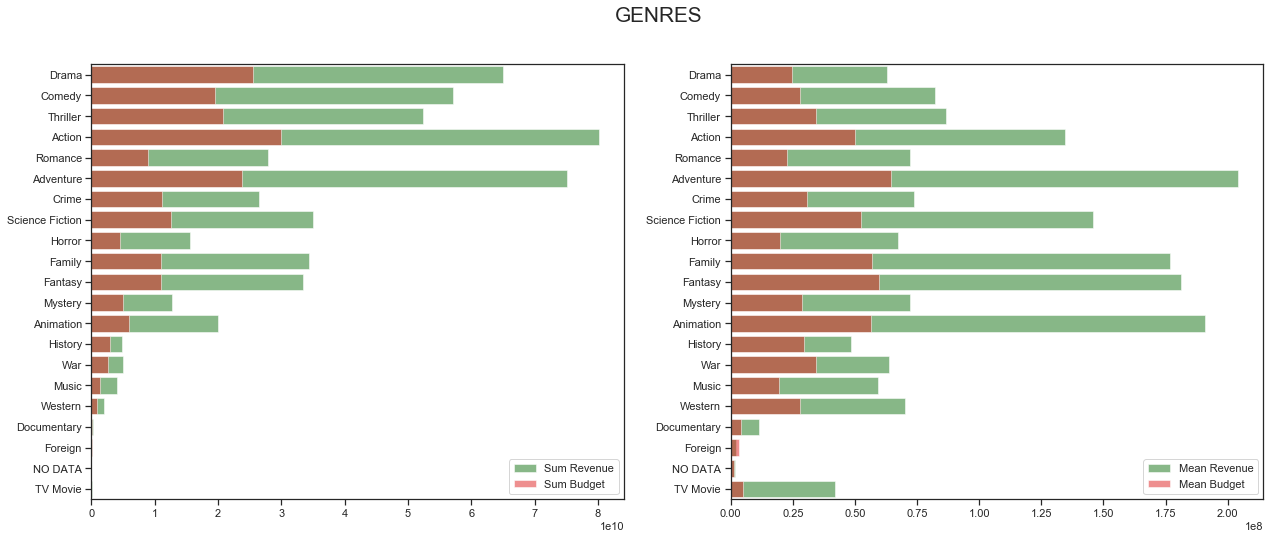

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 8), sharex=False)
ax1, ax2 = axes

barplot_movies(df=train_df, category="genres", agg="sum", ax=ax1, data_to_find=top_counts_df)
barplot_movies(df=train_df, category="genres", agg="mean", ax=ax2, data_to_find=top_counts_df)

for ax in axes:
    ax.legend(loc="lower right")

fig.suptitle("GENRES", fontsize="xx-large");

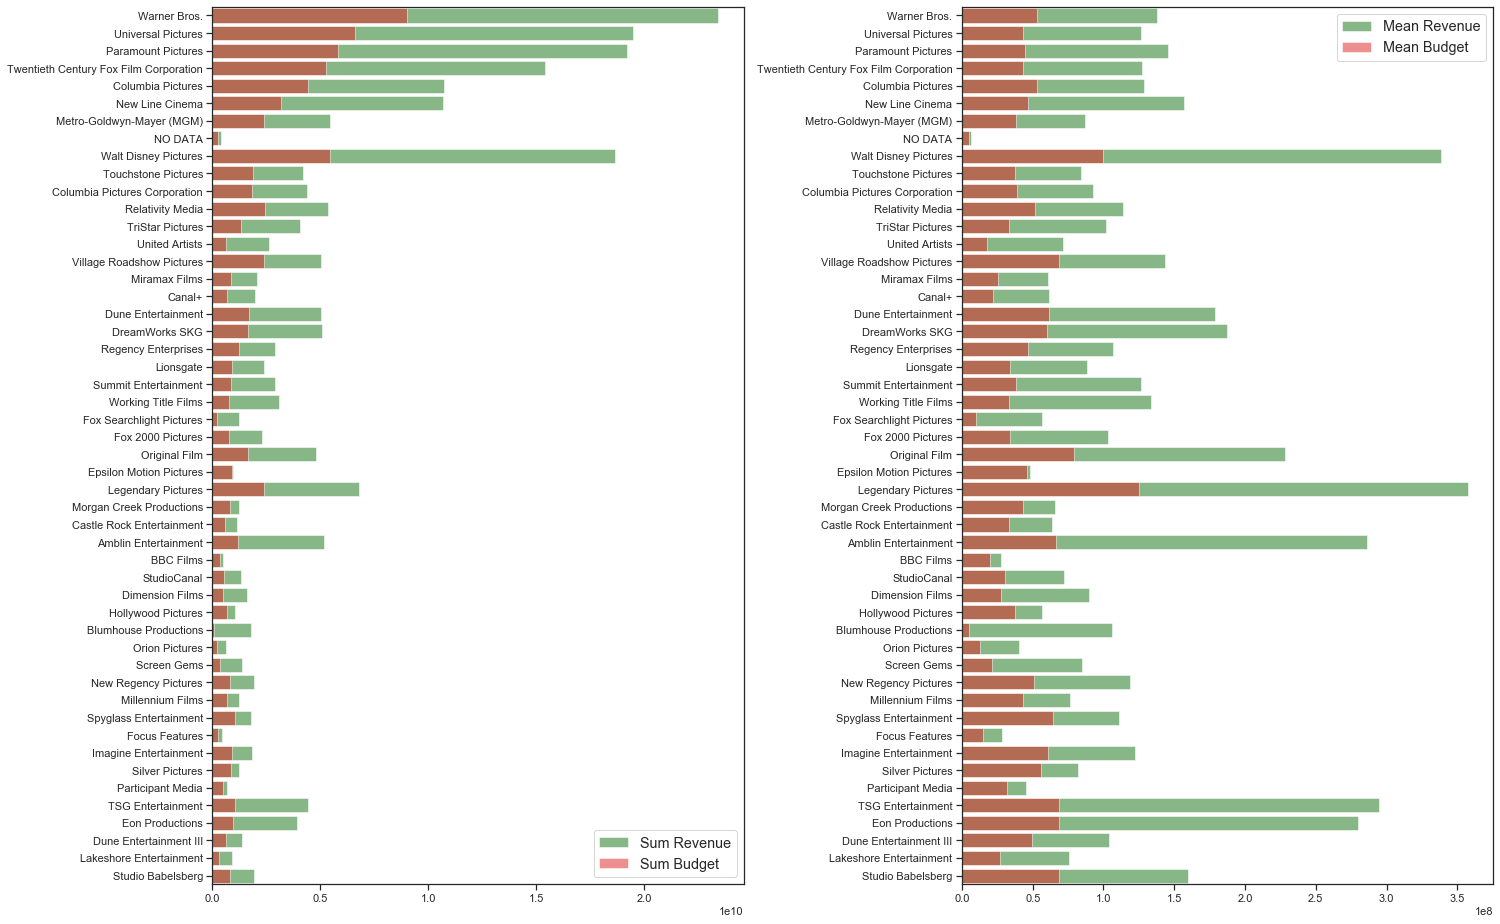

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 13), sharex=False)
ax1, ax2 = axes

barplot_movies(df=train_df, category="production_companies", agg="sum", ax=ax1, data_to_find=top_counts_df, top=50)
barplot_movies(df=train_df, category="production_companies", agg="mean", ax=ax2, data_to_find=top_counts_df, top=50)

plt.tight_layout()

Why does Legendary Pictures have more average revenue than Disney?

In [20]:
movie_search(train_df, "legendary pictures", "production_companies")[["title", "budget", "revenue", "adjusted_roi"]].sort_values("adjusted_roi", ascending=False).head(10)

title     budget     revenue  adjusted_roi
471             The Hangover   35000000   459270619      6.561009
1673         The Dark Knight  185000000  1004558444      2.715023
906    The Dark Knight Rises  250000000  1084939099      2.169878
2404                The Town   37000000   154026136      2.081434
1512                 Krampus   15000000    61548707      2.051624
2167   The Hangover Part III  103000000   362000072      1.757282
133                 Due Date   65000000   211780824      1.629083
1601          Dracula Untold   70000000   215529201      1.539494
440   300: Rise of an Empire  110000000   337580051      1.534455
2357            Man of Steel  225000000   662845518      1.472990

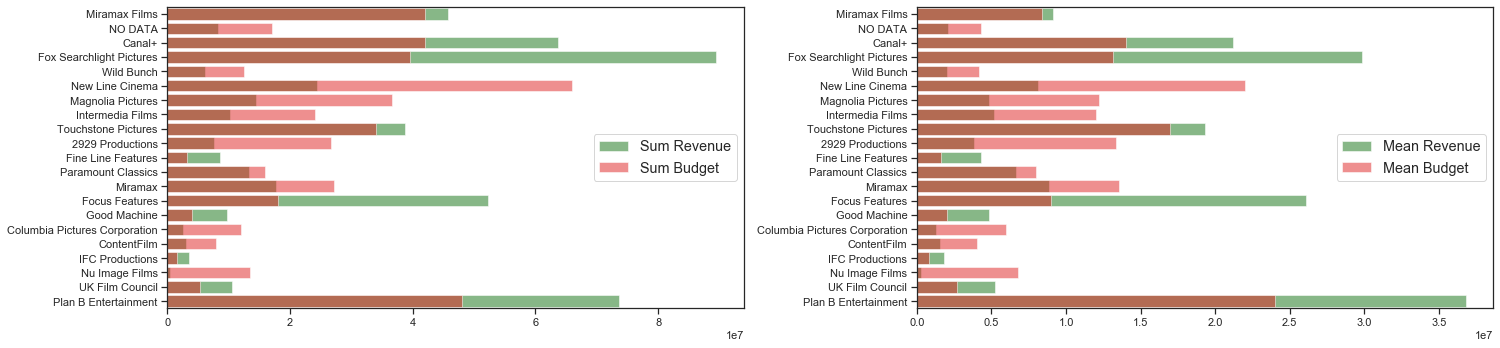

In [21]:
indie_df = movie_search(train_df, "independent film", "Keywords")

indie_counts_df = count_dict_items(df=indie_df, dct_columns=dictionary_columns)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21, 5), sharex=False)

barplot_movies(df=indie_df, category="production_companies", agg="sum", ax=ax1, data_to_find=indie_counts_df)
barplot_movies(df=indie_df, category="production_companies", agg="mean", ax=ax2, data_to_find=indie_counts_df)

plt.tight_layout()

In [22]:
indie_counts_df["production_companies"].dropna()

0                                  (Miramax Films, 5)
1                                        (NO DATA, 4)
2                                         (Canal+, 3)
3                       (Fox Searchlight Pictures, 3)
4                                     (Wild Bunch, 3)
                            ...                      
177    (Santa Fe Institute for Regional Education, 1)
178                            (Canon Productions, 1)
179                             (Icon Productions, 1)
180       (Twentieth Century Fox Film Corporation, 1)
181             (Icon Entertainment International, 1)
Name: production_companies, Length: 182, dtype: object

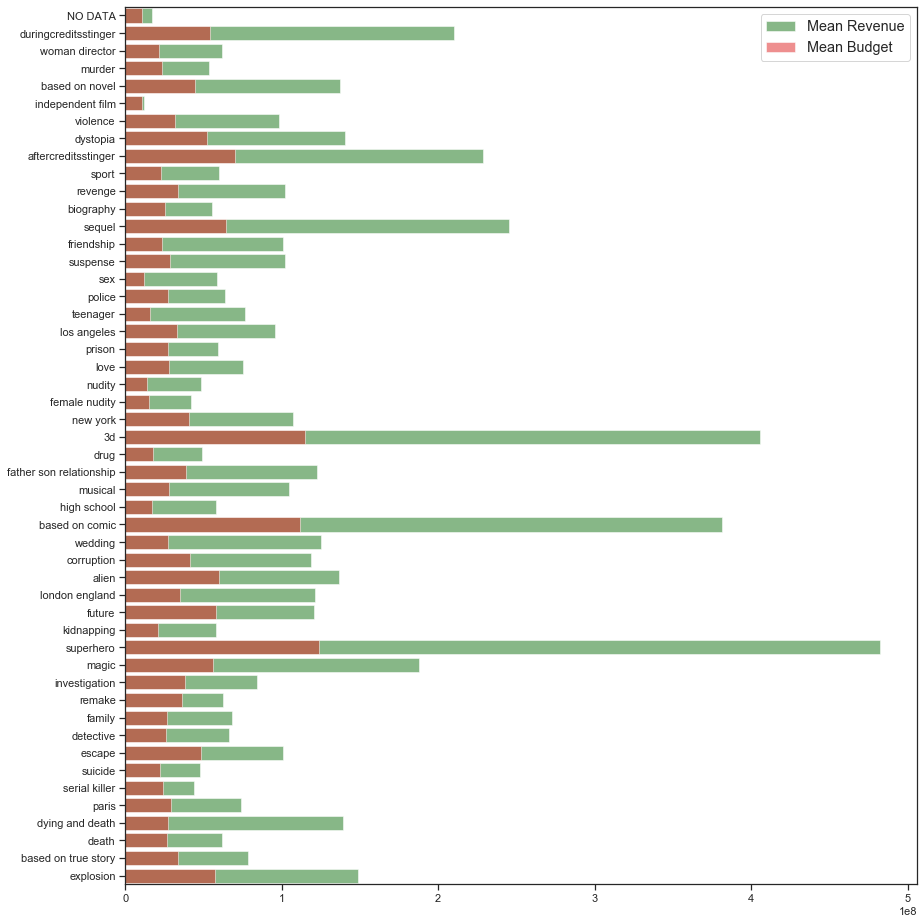

In [23]:
fig, ax = plt.subplots(figsize=(13,13))

barplot_movies(df=train_df, category="Keywords", agg="mean", ax=ax, data_to_find=top_counts_df, top=50)

plt.tight_layout()

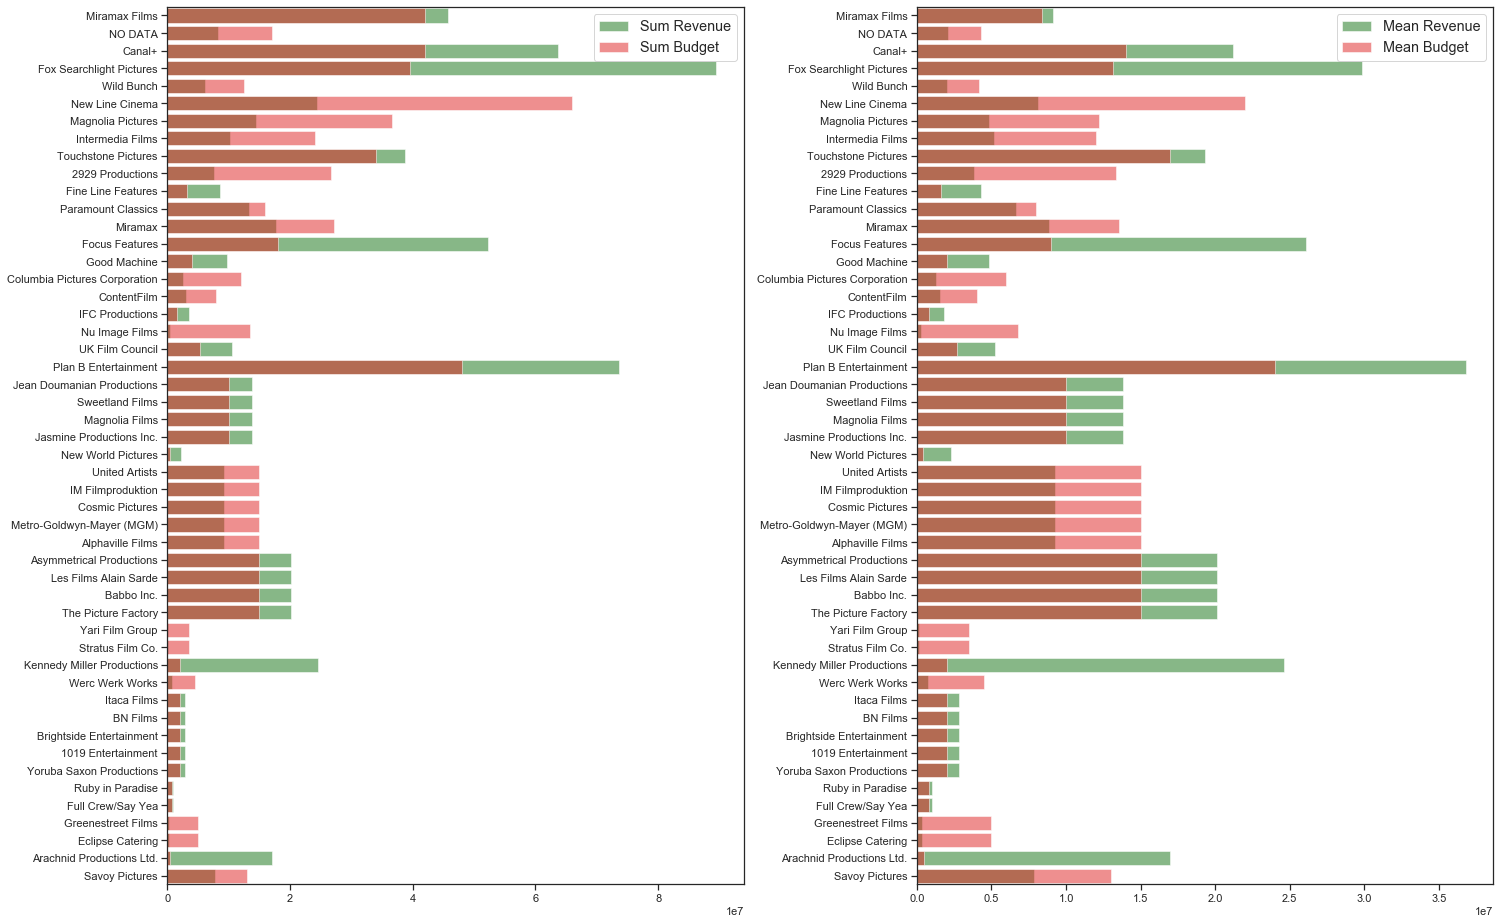

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,13))

barplot_movies(df=indie_df, category="production_companies", agg="sum", ax=ax1, data_to_find=indie_counts_df, top=50)
barplot_movies(df=indie_df, category="production_companies", agg="mean", ax=ax2, data_to_find=indie_counts_df, top=50)

plt.tight_layout()

#### Mann–Whitney U-Test on top four production companies with most data points 
It makes no distributional assumptions (unlike the t-test, which assumes the populations are normal), and can always be used instead.

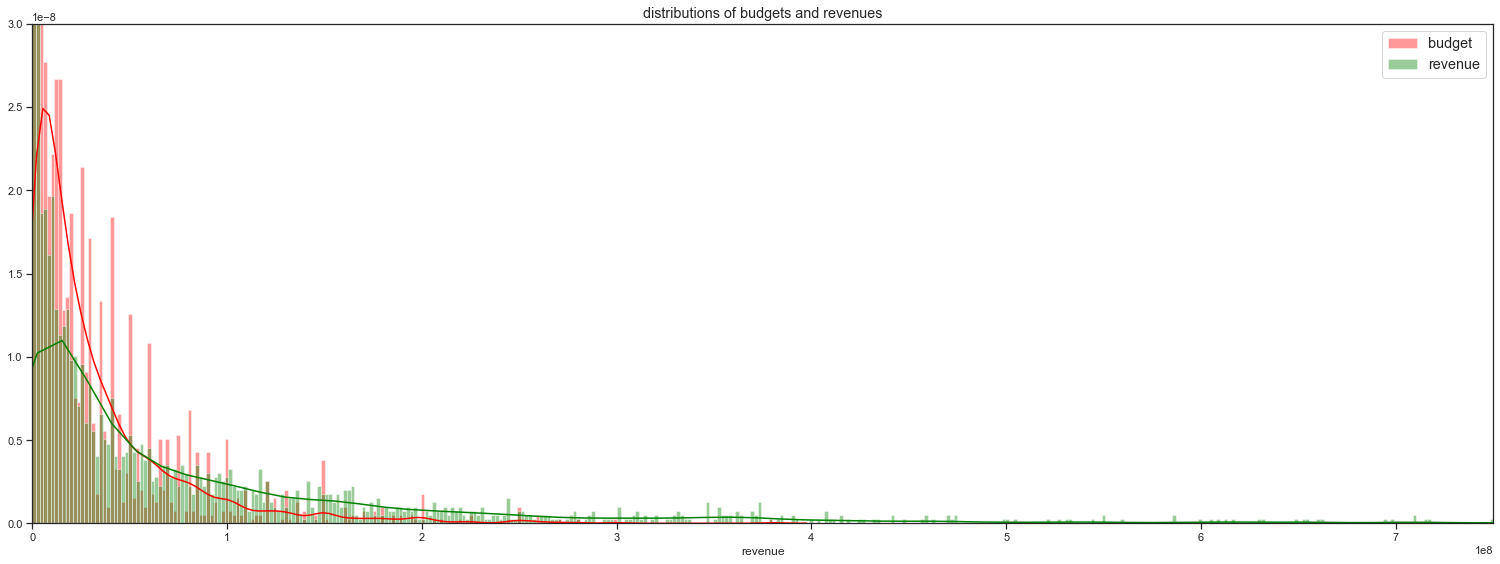

In [25]:
fig, ax = plt.subplots(figsize=(21,8))

sns.set_color_codes("colorblind")
sns.distplot(train_df["budget"], ax=ax, bins=200, label="budget", color="red")
sns.distplot(train_df["revenue"], ax=ax, bins=800, label="revenue", color="green")

ax.set_xlim(0, 750_000_000)
ax.set_ylim(0, 0.00000003)

ax.legend(fontsize="large")
ax.set_title("distributions of budgets and revenues", fontsize="large")

plt.tight_layout()

In [26]:
production_company_dfs = dataframe_dictionary(df=train_df, category="production_companies", data_to_find=top_counts_df)

In [27]:
significance_level = 0.05

for i, (production_company, _) in enumerate(top_counts_df["production_companies"][:4]):
    for production_company2, __ in top_counts_df["production_companies"][i+1:4]:
        wins1 = count_winning_pairs(production_company_dfs[production_company.lower()]["adjusted_roi"], production_company_dfs[production_company2.lower()]["adjusted_roi"])
        print(f"{production_company} wins: {wins1}")
        wins2 = count_winning_pairs(production_company_dfs[production_company2.lower()]["adjusted_roi"], production_company_dfs[production_company.lower()]["adjusted_roi"])
        print(f"{production_company2} wins: {wins2}")
        
        if wins1 > wins2:
            print(f"Test: {production_company} better than {production_company2}")
            mannwhitneyu_pvalue = stats.mannwhitneyu(production_company_dfs[production_company.lower()]["adjusted_roi"],
                                                         production_company_dfs[production_company2.lower()]["adjusted_roi"],
                                                         alternative="greater").pvalue
            print(f"p-value for {production_company} < {production_company2}: {mannwhitneyu_pvalue}")
            if mannwhitneyu_pvalue < significance_level:
                print(f"There is evidence that shows {production_company} produces movies with a better return on investment than {production_company2}.")
            else:
                print(f"not enough evidence to conclude one is better than the other")
            
        elif wins1 < wins2:
            print(f"Test: {production_company2} better than {production_company}")
            mannwhitneyu_pvalue = stats.mannwhitneyu(production_company_dfs[production_company2.lower()]["adjusted_roi"],
                                                         production_company_dfs[production_company.lower()]["adjusted_roi"],
                                                         alternative="greater").pvalue
            print(f"p-value for {production_company2} < {production_company}: {mannwhitneyu_pvalue}")
            if mannwhitneyu_pvalue < significance_level:
                print(f"There is evidence that shows {production_company2} produces movies with a better return on investment than {production_company}.")
            else:
                print(f"There is not enough evidence to conclude one company produces movies with a better return on investment than the other.")
        else:
            print("tie")
        print()

Warner Bros. wins: 11769.0
Universal Pictures wins: 14411.0
Test: Universal Pictures better than Warner Bros.
p-value for Universal Pictures < Warner Bros.: 0.058416778367974646
There is not enough evidence to conclude one company produces movies with a better return on investment than the other.

Warner Bros. wins: 9762.5
Paramount Pictures wins: 12677.5
Test: Paramount Pictures better than Warner Bros.
p-value for Paramount Pictures < Warner Bros.: 0.026457819091269066
There is evidence that shows Paramount Pictures produces movies with a better return on investment than Warner Bros..

Warner Bros. wins: 9036.5
Twentieth Century Fox Film Corporation wins: 11533.5
Test: Twentieth Century Fox Film Corporation better than Warner Bros.
p-value for Twentieth Century Fox Film Corporation < Warner Bros.: 0.03886663621839529
There is evidence that shows Twentieth Century Fox Film Corporation produces movies with a better return on investment than Warner Bros..

Universal Pictures wins: 9788.

In [28]:
movie_search(production_company_dfs["warner bros."], "comedy", "genres")["adjusted_roi"].describe()

count    50.000000
mean      1.904352
std       3.369400
min       0.068084
25%       0.637578
50%       1.066744
75%       1.673236
max      22.980769
Name: adjusted_roi, dtype: float64

In [29]:
successful_movies = (train_df["adjusted_roi"] > 1).sum()
num_of_samples = len(train_df["adjusted_roi"])

print("percent of movies in dataset that make at least twice as much revenue than budget spent:")
(successful_movies / num_of_samples)

percent of movies in dataset that make at least twice as much revenue than budget spent:


0.5155428024868484